In [ ]:
!pip install bing-image-downloader tensorflow opencv-python matplotlib seaborn scikit-learn pandas

In [ ]:
import os
import shutil
from bing_image_downloader import downloader

# 1. Definisi Kelas dan Konfigurasi
classes = [
    "pensil",
    "eraser",
    "kertas",
]

# Nama folder output
dataset_dir = 'dataset_alat_tulis'

# Bersihkan folder jika sudah ada (untuk fresh start)
if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)

# 2. Proses Scraping
for category in classes:
    # Menambahkan keyword visual agar background putih
    query_string = f"{category}"

    print(f"Sedang mengunduh gambar untuk kelas: {category}...")

    downloader.download(
        query_string,
        limit=80,  # Jumlah gambar per kelas
        output_dir=dataset_dir,
        adult_filter_off=True,
        force_replace=False,
        timeout=60,
        verbose=False
    )

    # Rename folder agar sesuai nama kelas yang simpel (opsional, untuk kerapihan)
    # Bing downloader membuat folder berdasarkan query panjang, kita bisa rename manual atau biarkan
    # Disini kita biarkan folder sesuai query agar tertata.

print("\nSelesai mengunduh data!")

Sedang mengunduh gambar untuk kelas: pensil...
[%] Downloading Images to /content/dataset_alat_tulis/pensil
[!] Issue getting: https://media.istockphoto.com/id/1179843919/id/foto/pensil-di-atas-meja.jpg?s=1024x1024&amp;w=is&amp;k=20&amp;c=F69VpLaJvcEYU8mkQTU_tPGBAfgDJCfU7WsLtODT8zw=
[!] Error:: HTTP Error 400: Bad Request
[!] Issue getting: https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiMdYmbWlrTEYL1Cph7R9OV-8ZM84cngZXjMVSObBVbv1wgwfK_4yoNVUiOIT_fJC4krDyLAoDqdCKo17f7BaO5vPdqjGdmZ2CFddXT882CWrWyIgj3NPrPgbVV_8Vc-7IZoJFcmE3jSywWUUwz5QXGbUAm_PtqA2xjoOxckucE8DPNg80gvMDG86dC/s1217/Pensil Gambar.jpg
[!] Error:: URL can't contain control characters. '/img/b/R29vZ2xl/AVvXsEiMdYmbWlrTEYL1Cph7R9OV-8ZM84cngZXjMVSObBVbv1wgwfK_4yoNVUiOIT_fJC4krDyLAoDqdCKo17f7BaO5vPdqjGdmZ2CFddXT882CWrWyIgj3NPrPgbVV_8Vc-7IZoJFcmE3jSywWUUwz5QXGbUAm_PtqA2xjoOxckucE8DPNg80gvMDG86dC/s1217/Pensil Gambar.jpg' (found at least ' ')
[!] Issue getting: https://png.pngtree.com/png-clipart/20230227/original/pngtree-

In [ ]:
import tensorflow as tf
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

# Konfigurasi Gambar
IMG_HEIGHT = 300
IMG_WIDTH = 300
BATCH_SIZE = 15

# Hapus gambar yang corrupt/rusak (Penting hasil scraping sering ada file error)
data_dir = dataset_dir
image_exts = ['jpeg','jpg', 'png'] # Removed 'webp' as it causes InvalidArgumentError in TensorFlow decoding

print("Memeriksa file gambar yang rusak...")
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print(f'Image not in ext list {image_path}')
                    os.remove(image_path)
            except Exception as e:
                print(f'Issue with image {image_path}')
                os.remove(image_path)

# Load Dataset & Split (80:20)
# Labeling otomatis terjadi disini (inferred from directory names)
print("\nMembuat Dataset Training & Validation...")

# Training Set (90%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Validation/Test Set (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Mendapatkan nama kelas
class_names = train_ds.class_names
print(f"Kelas terdeteksi: {class_names}")

# Optimasi performa loading data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Memeriksa file gambar yang rusak...
Image not in ext list dataset_alat_tulis/eraser/Image_37.jpg
Image not in ext list dataset_alat_tulis/eraser/Image_68.jpg
Image not in ext list dataset_alat_tulis/eraser/Image_10.jpg
Image not in ext list dataset_alat_tulis/pensil/Image_49.webp
Image not in ext list dataset_alat_tulis/pensil/Image_11.jpg
Image not in ext list dataset_alat_tulis/kertas/Image_55.webp
Image not in ext list dataset_alat_tulis/kertas/Image_45.webp
Image not in ext list dataset_alat_tulis/kertas/Image_41.webp
Image not in ext list dataset_alat_tulis/kertas/Image_68.webp

Membuat Dataset Training & Validation...
Found 231 files belonging to 3 classes.
Using 208 files for training.
Found 231 files belonging to 3 classes.
Using 23 files for validation.
Kelas terdeteksi: ['eraser', 'kertas', 'pensil']


In [ ]:
from tensorflow.keras import layers, models

num_classes = len(class_names)

model = models.Sequential([
    # Layer Preprocessing (Rescaling 1./255)
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Layer Konvolusi 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Layer Konvolusi 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Layer Konvolusi 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Flatten & Dense
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # Dropout untuk mencegah overfitting

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    22,429,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,523,459 (85.92 MB)

 Trainable params: 22,523,459 (85.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 645ms/step - accuracy: 0.3968 - loss: 4.4295 - val_accuracy: 0.3913 - val_loss: 1.0396
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4855 - loss: 1.0351 - val_accuracy: 0.4348 - val_loss: 1.0237
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5642 - loss: 1.0490 - val_accuracy: 0.5652 - val_loss: 0.9795
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6826 - loss: 0.7170 - val_accuracy: 0.4783 - val_loss: 1.2119
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7786 - loss: 0.6013 - val_accuracy: 0.5652 - val_loss: 1.0907
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8017 - loss: 0.4391 - val_accuracy: 0.7391 - val_loss: 0.9184
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9110 - loss: 0.2082 - val_accuracy: 0.6957 - val_loss: 1.4111
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8759 - loss: 0.3096 - val_accuracy: 0.8696 -

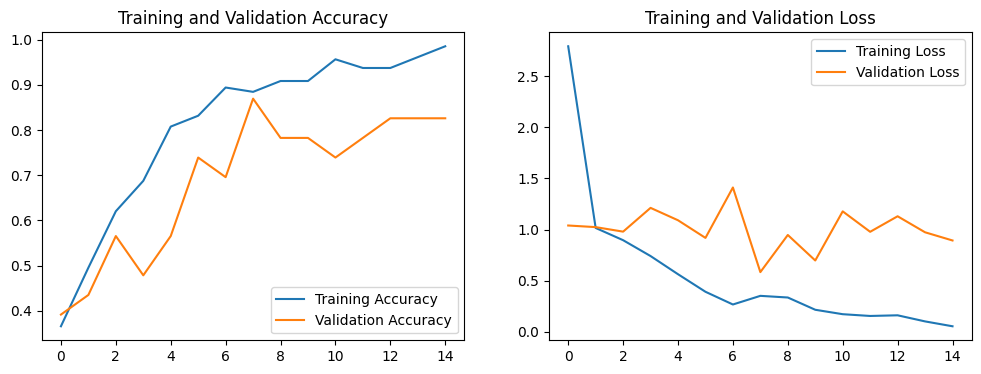

In [ ]:
epochs = 15 # Anda bisa sesuaikan jumlah epoch

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Visualisasi Hasil Training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


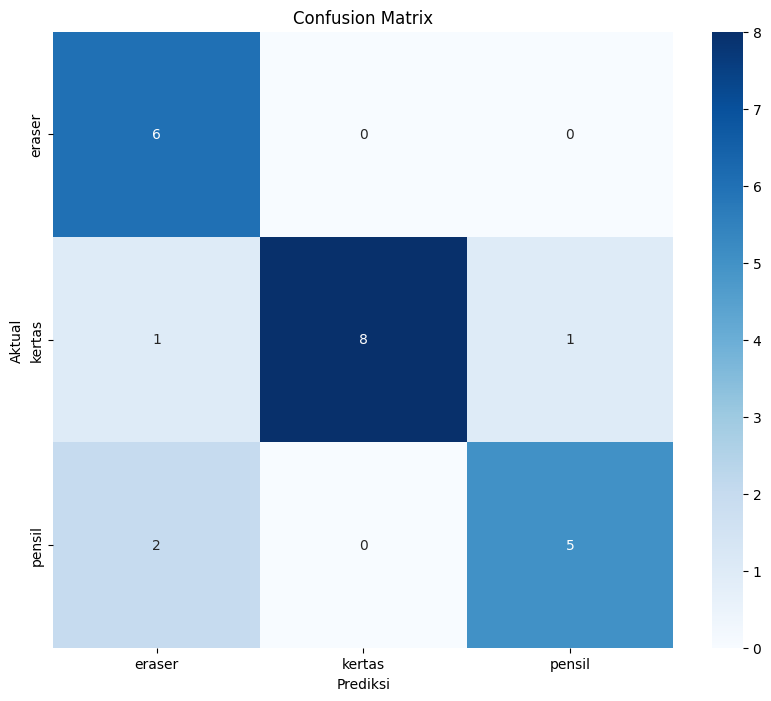


Laporan Klasifikasi Lengkap:
              precision    recall  f1-score   support

      eraser       0.67      1.00      0.80         6
      kertas       1.00      0.80      0.89        10
      pensil       0.83      0.71      0.77         7

    accuracy                           0.83        23
   macro avg       0.83      0.84      0.82        23
weighted avg       0.86      0.83      0.83        23



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Mengambil label asli dan prediksi dari dataset validasi
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

# 2. Accuracy, Precision, Recall, F1-Score
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers

# 1. Definisikan Fungsi Model Builder
def build_model(hp):
    model = models.Sequential()

    # Preprocessing
    model.add(layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    # Tuning Jumlah Filter di Conv Layer 1
    # hp.Int akan mencoba nilai antara 32 sampai 128 dengan kelipatan 32
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        kernel_size=3,
        padding='same',
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())

    # Tuning Jumlah Filter di Conv Layer 2
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),
        kernel_size=3,
        padding='same',
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())

    # Tuning Jumlah Unit di Dense Layer
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))

    # Tuning Dropout Rate (misal 0.2, 0.3, s/d 0.5)
    model.add(layers.Dropout(
        rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    ))

    # Output Layer
    model.add(layers.Dense(len(class_names), activation='softmax'))

    # Tuning Learning Rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

# 2. Inisialisasi Tuner
# Hyperband adalah algoritma pencarian yang cepat dan efisien
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='my_dir',       # Folder untuk menyimpan log
    project_name='alat_tulis_tuning',
    max_trials=10
)

# Callback untuk menghentikan training jika tidak ada perbaikan (Early Stopping)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Memulai pencarian hyperparameter terbaik...")

# 3. Jalankan Pencarian (Search)
tuner.search(train_ds, epochs=15, validation_data=val_ds, callbacks=[stop_early])

# Dapatkan Hyperparameter Terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Pencarian Selesai.
Jumlah Filter Conv 1 Terbaik: {best_hps.get('conv_1_filter')}
Jumlah Filter Conv 2 Terbaik: {best_hps.get('conv_2_filter')}
Jumlah Unit Dense Terbaik: {best_hps.get('dense_units')}
Dropout Rate Terbaik: {best_hps.get('dropout')}
Learning Rate Terbaik: {best_hps.get('learning_rate')}
""")

ValueError: Unrecognized arguments ['max_trials'] for `BaseTuner.__init__()`.

In [ ]:
# 1. Build model dengan hyperparameter terbaik
model = tuner.hypermodel.build(best_hps)

# 2. Train model terbaik
# Kita gunakan jumlah epoch yang agak lebih banyak karena kita sudah yakin dengan arsitekturnya
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[stop_early] # Tetap gunakan early stopping agar tidak membuang waktu
)

# Visualisasi (Sama seperti sebelumnya, tapi sekarang untuk model hasil tuning)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Tuned Model)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (Tuned Model)')
plt.legend()
plt.show()

NameError: name 'best_hps' is not defined